# Tropes Analysis
This section will examine the relationship between TV tropes present and movie success

## Expanding tropes dataset
We will start by adding useful columns to the TV tropes dataset

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../utils/')

import tropes_utils


In [2]:
tropes_df = pd.read_pickle('../../pickles/tropes_df.pkl')
characters_df = pd.read_pickle('../../pickles/character_metadata.pkl')
cmu_movies_df = pd.read_pickle('../../pickles/cmu_movies_df.pkl')
movie_scores = pd.read_pickle('../../pickles/movie_scores.pkl')

In [3]:
# left join tropes and characters
tropes_chars_df = pd.merge(tropes_df, characters_df, on='character_actor_map_id', how='left')

# left join tropes + characters and movies
cmu_movies_df.rename(columns={'Freebase Movie ID': 'freebase_movie_id'}, inplace=True)
tropes_chars_movies_df = pd.merge(tropes_chars_df, cmu_movies_df, on='freebase_movie_id', how='left')

# left join tropes + success metrics
movie_scores.rename(columns={'movie_name': 'movie'}, inplace=True)
tropes_all = pd.merge(tropes_chars_movies_df, movie_scores, on='movie', how='left')

tropes_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   char                    501 non-null    object 
 1   movie                   501 non-null    object 
 2   character_actor_map_id  501 non-null    object 
 3   actor                   501 non-null    object 
 4   trope                   501 non-null    object 
 5   wikipedia_movie_id      501 non-null    int64  
 6   freebase_movie_id       501 non-null    object 
 7   movie_release_date      501 non-null    object 
 8   character_name          501 non-null    object 
 9   actor_dob               499 non-null    object 
 10  actor_gender            500 non-null    object 
 11  actor_height            469 non-null    float64
 12  actor_ethnicity_id      333 non-null    object 
 13  actor_name              501 non-null    object 
 14  actor_age_at_release    483 non-null    fl

## Cleaning the data

### Visualizing missing data

We first visualize the columns which have missing values and then decide what to do with them

/Users/adamborgula/.pyenv/versions/epfl-ai/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


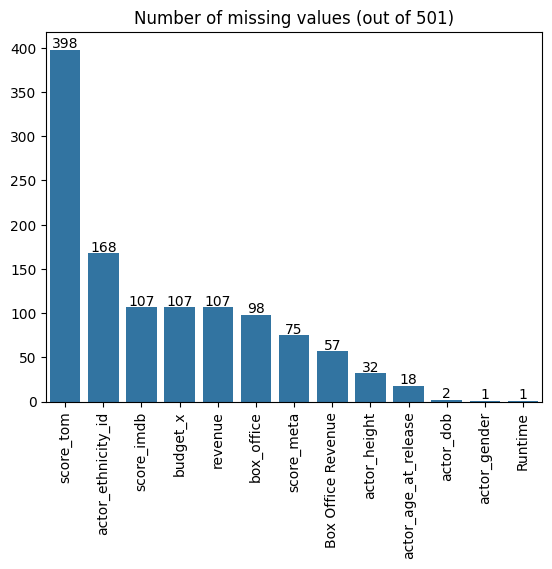

In [4]:
tropes_utils.plot_missing_data(tropes_all)

Observe that 4 columns have a significant amount of values missing:
1. actor_ethnicity_id
2. Box Office Revenue
3. actor_height
4. actor_age_at_realease

We do not care about the ethnicity nor height in this analysis.

However, **missing box office revenue** data as well as **actor age** data is something we need to keep in mind later in the analysis

### Dropping irrelevant columns

In [5]:
tropes_scores = tropes_all[['char', 'movie', 'actor', 'trope', 
                                'actor_gender', 
                                'actor_age_at_release', 'actor_dob', 'Release Date',  
                                'Box Office Revenue', 'Runtime', 'Language Name',
                                'Country Name', 'Genre Name',
                                'score_tom', 'score_imdb', 'budget_x', 'revenue', 'box_office', 'score_meta']]

### Enriching the data

We have actor's date of birth in **actor_dob** as well as **Release Date**, so we can fill in the missing values in **actor_age_at_release**

/var/folders/jh/wtzfr62x0vd4dklqkf69gcv00000gn/T/ipykernel_66893/1605097733.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_scores.drop(columns=['actor_dob'], inplace=True)
/Users/adamborgula/.pyenv/versions/epfl-ai/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


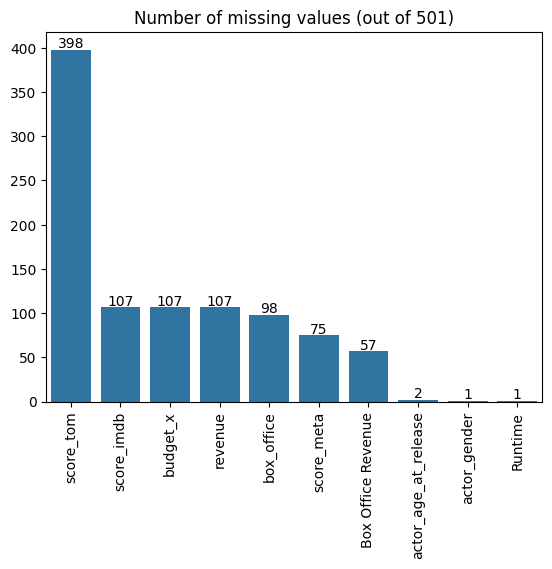

In [6]:
# get boolean True for rows with missing actor_age_at_release
filter = tropes_scores['actor_age_at_release'].isna()
missing_age = tropes_scores[filter]

# replace missing rows
tropes_scores.loc[filter, 'actor_age_at_release']  = missing_age.apply(
    lambda row: (pd.to_datetime(row['Release Date']).year - pd.to_datetime(row['actor_dob']).year)
    if pd.notnull(row['actor_dob']) else np.nan,
    axis=1
)

# Drop the column actor_dob
tropes_scores.drop(columns=['actor_dob'], inplace=True)

# plot missing data
tropes_utils.plot_missing_data(tropes_scores)

We have successfully substituted the missing values for actor's age. Note, that the actual age may vary by 1 year, since we only looked at the year of birth and release to compute actor's age (we did not consider the exact date).

## Analysis

Now, we know what data we are working with, so we can proceed with the analysis. I will first list what kind of relationships we are looking at and then present the results.

**General**

1. Plot the number of movies each trope appears in
2. Plot the gender distribution for each trope
3. Plot the age distribution of each trope
4. Plot the trope-runtime relationship

**Financial Success**

5. Plot which tropes have box office column missing
6. Plot the total gross for each trope divided by the number of characters it used
7. Plot the trope-genre heatmap and box office
8. Plot the trope-gender relationship heatmap for box office
9. Plot the trope-age relationship
10. Rank them and summarize results

**Positive Audience Reception**
- repeat analysis as in the section above, but with *score_imdb* and *score_meta* instead of *box office revenue* (both separately and combined)

### General Analysis

The goal of this general subsection is to familiarize ourselves with the tropes dataset. It is a necessary step before doing further analysis and drawing conclusions.

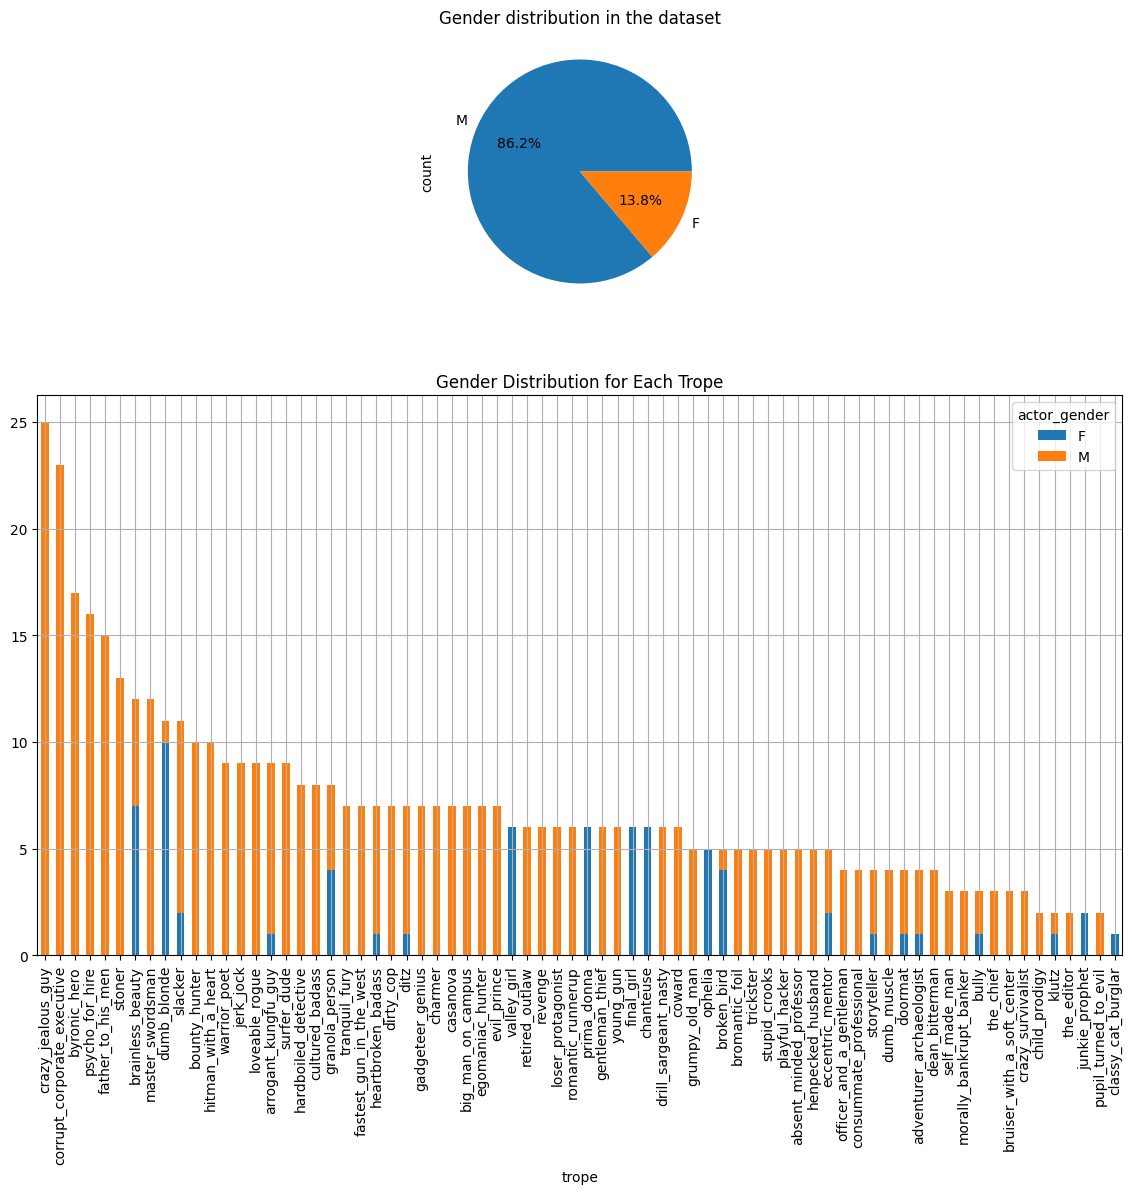

In [7]:
tropes_utils.plot_gender_distribution(tropes_scores)

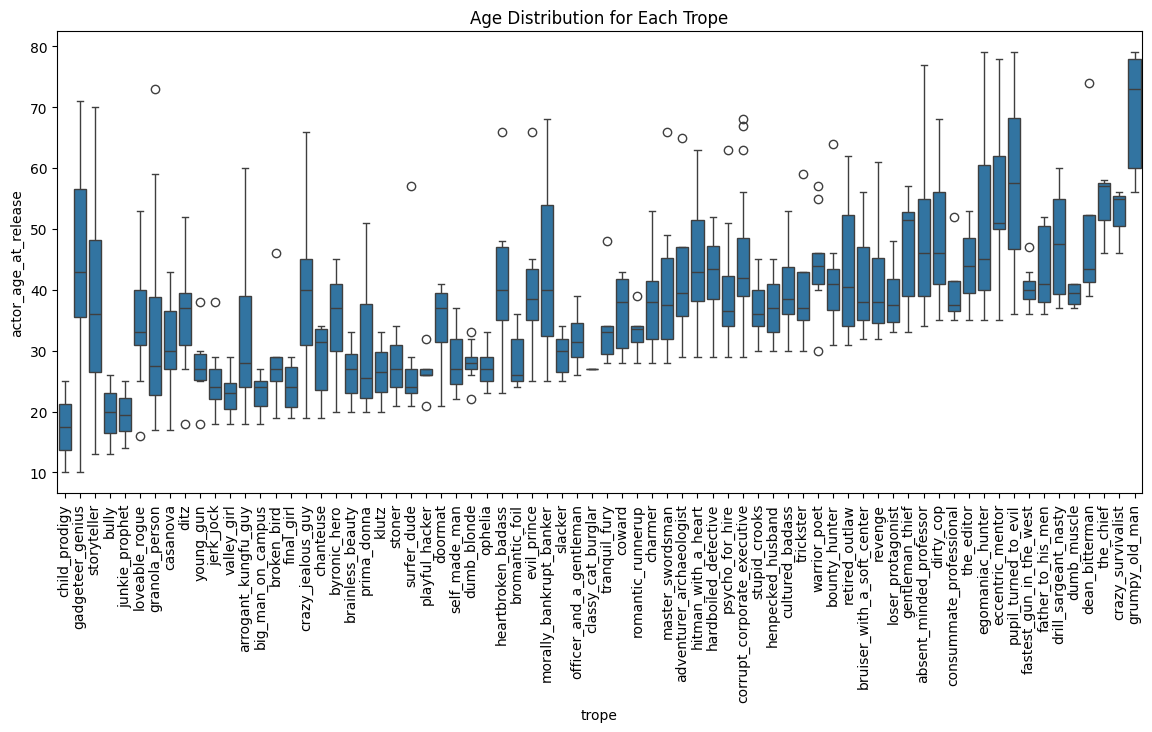

In [8]:
tropes_utils.plot_age_distribution(tropes_scores)

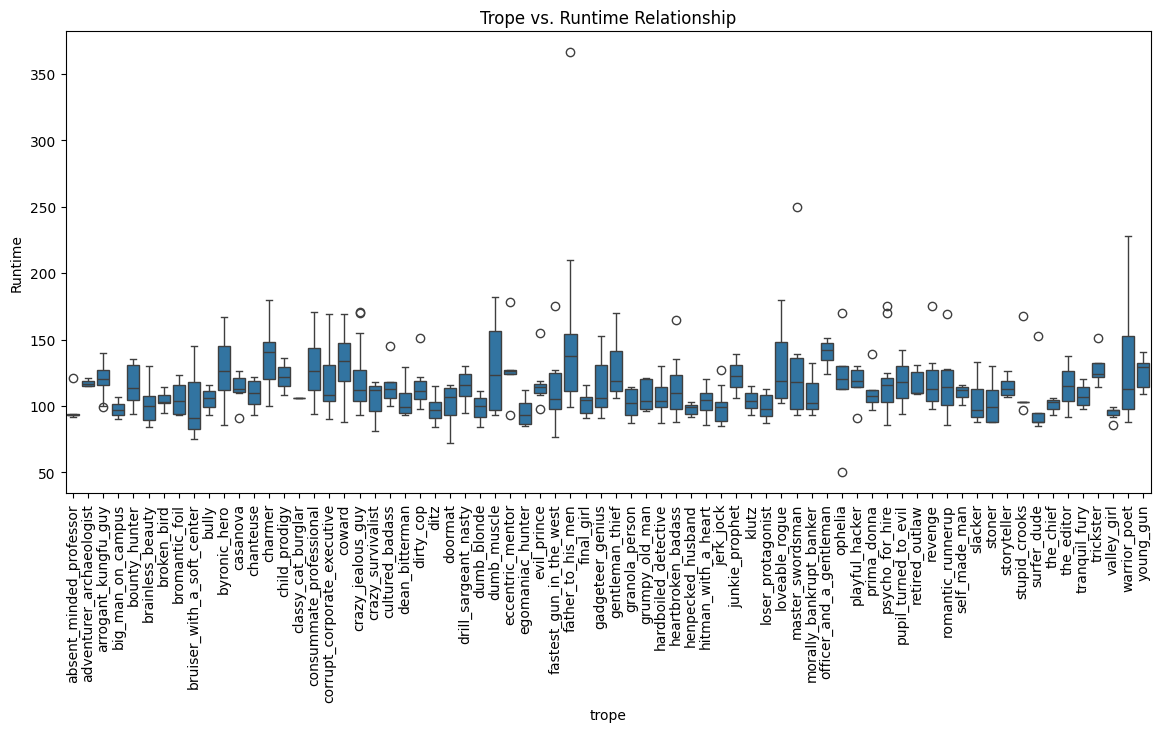

In [9]:
tropes_utils.plot_runtime_distribution(tropes_scores)

**Count & gender:** From the first 2 plots, we can see that majority **(86.2%)** of the tropes are represented by **men** in our dataset.

**Age:** The plot with age shows that there seems to be a relationship between the tropes and their age, but the **variance is high**. We could later look at the tropes with the lowest variance in age if we wanted to draw significant results.

**Runtime:** For now, it seems like all the tropes appear in movies with very similar runtime. It seems this column irrelevant and we could exclude it.

### Financial Succcess Analysis
Let us first examine how many box office entries there are missing.

/Users/adamborgula/dev/epfl/ada-2024-project-bluesweater/src/sections/../utils/tropes_utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, trope_counts['Box Office Not Missing'][i] + trope_counts['Missing Box Office'][i] + 0.5, int(missing*100), fontsize='xx-small', ha='center')


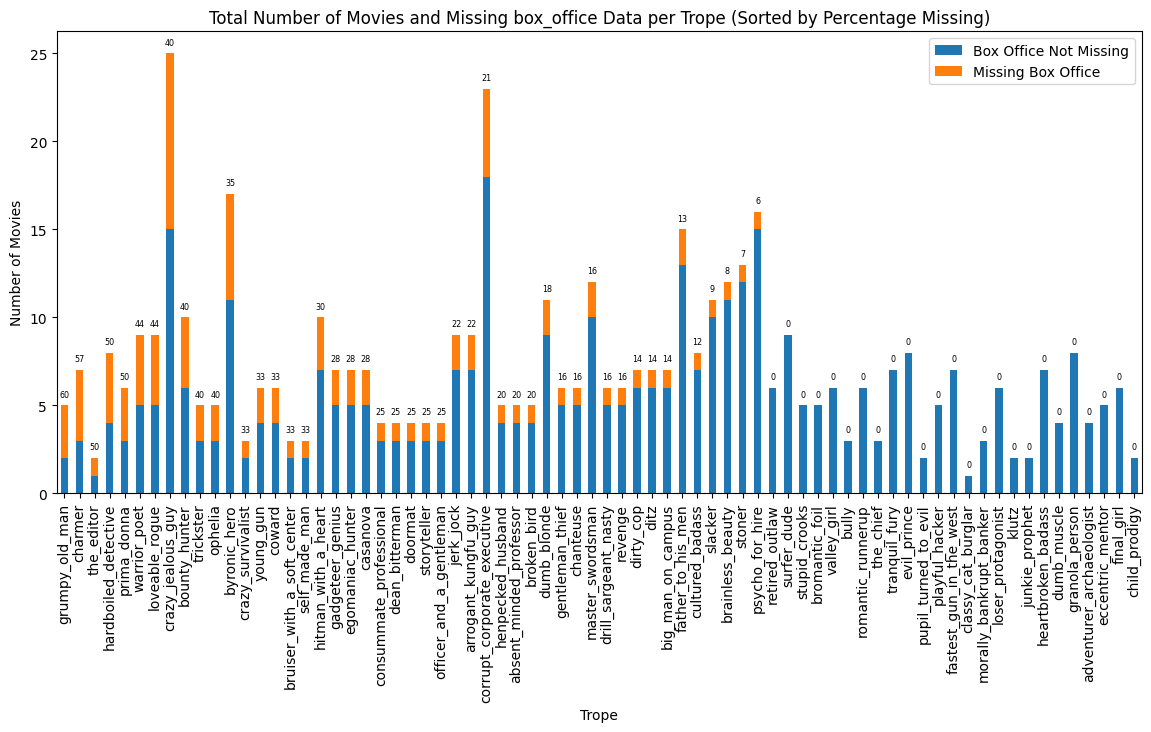

In [10]:
tropes_utils.plot_success_metric_missing(tropes_scores)

We can see that for each trope, at least some movies still contain the box office info and that is the most important for us. 

The dataset of tropes contained just ±500 samples to begin with. We therefore need to keep in mind that the results we draw might not generalize over all movies. However, it is still interesting to examine which tropes predict the biggest box office revenue, so let us look at exactly that.

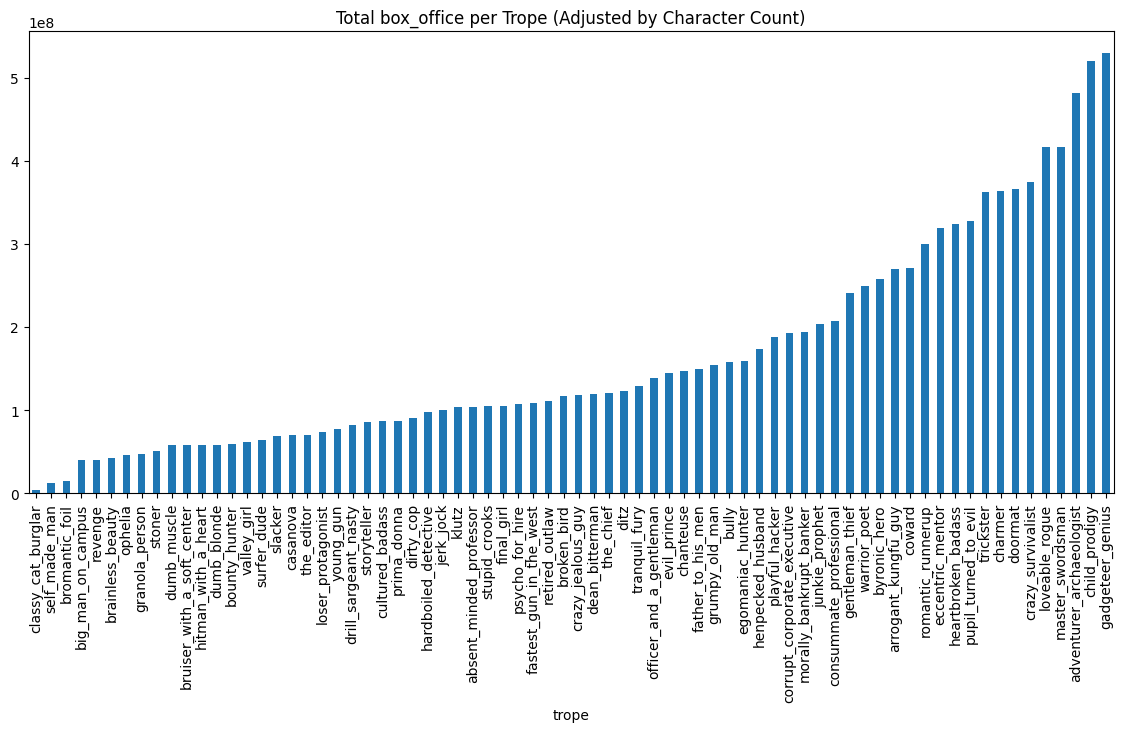

In [11]:
tropes_utils.plot_success_metric_per_trope(tropes_scores)

In [12]:
tropes_utils.show_most_successful_tropes(tropes_scores, items=5)

trope
gadgeteer_genius            529029503
child_prodigy               519998348
adventurer_archaeologist    481400670
master_swordsman            416158747
loveable_rogue              416047100
Name: box_office, dtype: int64


The **5 most profitable tropes** seem to be:
1. gadgeteer_genius
2. child_prodigy
3. adventure_archeologist
4. master_swordsman
5. loveable_rogue

### Critics Analysis
Now, let us look at the metacritic ratings and discover the top tropes there

/Users/adamborgula/dev/epfl/ada-2024-project-bluesweater/src/sections/../utils/tropes_utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, trope_counts['Box Office Not Missing'][i] + trope_counts['Missing Box Office'][i] + 0.5, int(missing*100), fontsize='xx-small', ha='center')


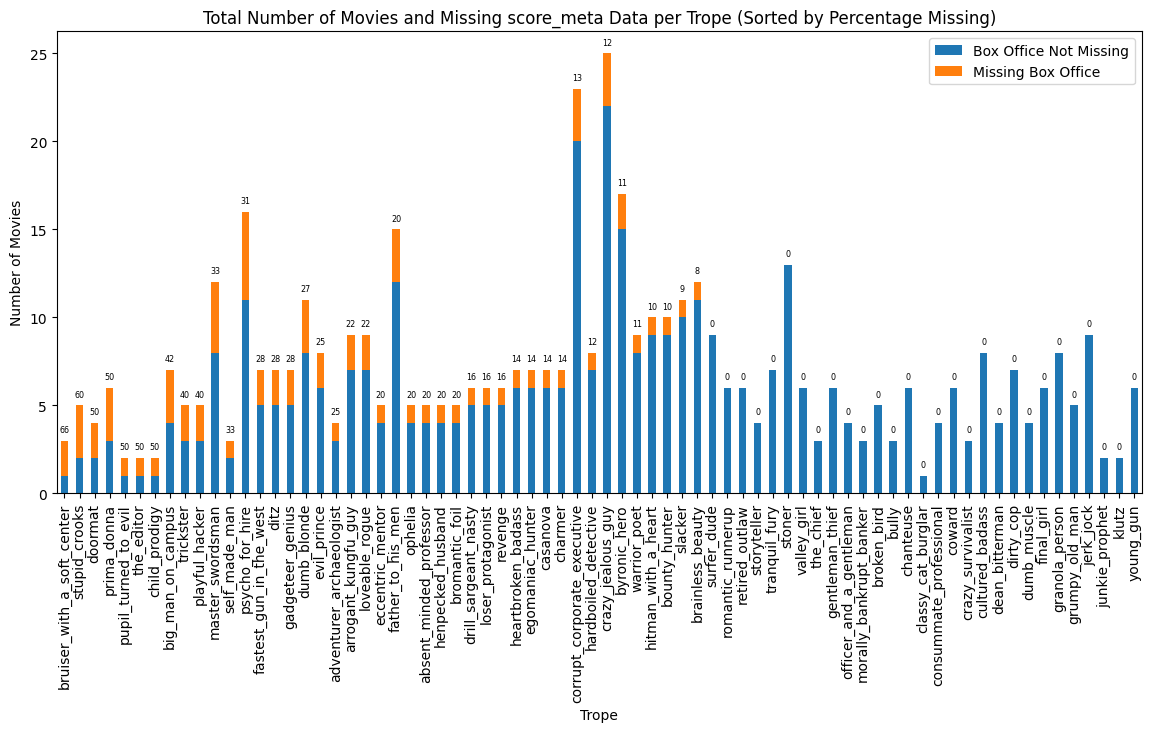

In [13]:
tropes_utils.plot_success_metric_missing(tropes_scores, success_metric='score_meta')

Each trope has at least one example, which is again the most important for us right now. Also notice that child prodigy, who was the winner before now has 1 out of 2 data points missing, so the comparison is not exactly 1 to 1, even for the top movies, unfortunatelly.

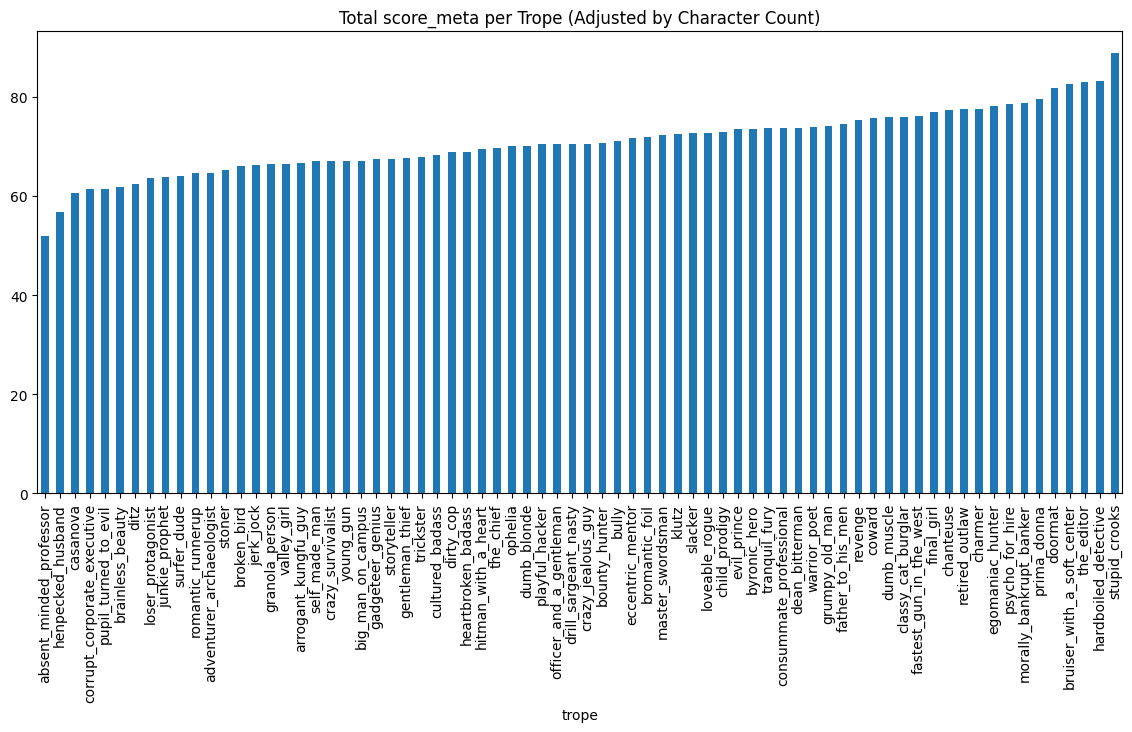

In [14]:
tropes_utils.plot_success_metric_per_trope(tropes_scores, success_metric='score_meta')

In [15]:
tropes_utils.show_most_successful_tropes(tropes_scores, items=10, success_metric='score_meta')

trope
stupid_crooks                 88
hardboiled_detective          83
the_editor                    83
bruiser_with_a_soft_center    82
doormat                       81
prima_donna                   79
morally_bankrupt_banker       78
psycho_for_hire               78
egomaniac_hunter              78
retired_outlaw                77
Name: score_meta, dtype: int64


The metacritic score goes from 0 to 100. We can observe that all of these movies have scores above 50, but there are only 5 movies with scores above 80. Namely:

1. stupid_crooks
2. hardboiled_detective
3. the_editor
4. bruiser_with_a_soft_center
5. doormat

We can see that **stupid_crooks** have the biggest score by extra 5 points. There is unfortunatelly no overlap with the movies who had the biggest gross, unfortunatelly.

### Audience Reception Analysis
Lastly, we will look at the audience ratings and see which tropes rank best. We will be using IMDb scores for that.

/Users/adamborgula/dev/epfl/ada-2024-project-bluesweater/src/sections/../utils/tropes_utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, trope_counts['Box Office Not Missing'][i] + trope_counts['Missing Box Office'][i] + 0.5, int(missing*100), fontsize='xx-small', ha='center')


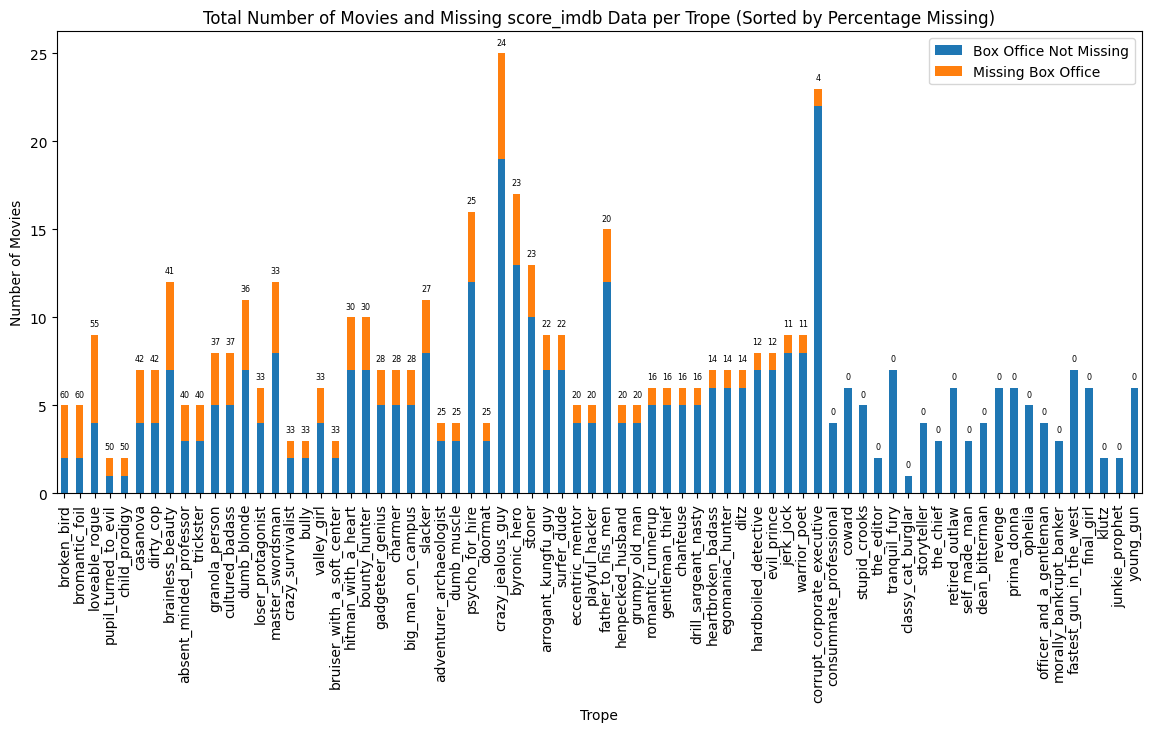

In [16]:
tropes_utils.plot_success_metric_missing(tropes_scores, success_metric='score_imdb')

Again, having a more complete datasaet would be ideal, but atleast some data is present for each trope.

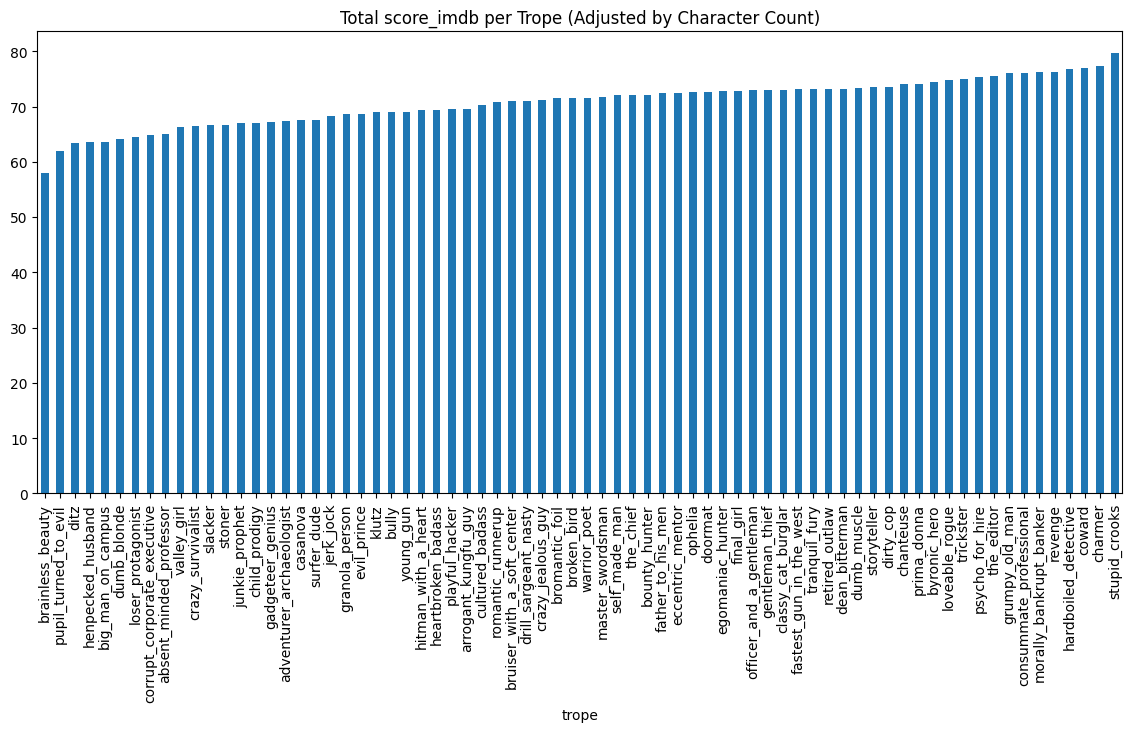

In [17]:
tropes_utils.plot_success_metric_per_trope(tropes_scores, success_metric='score_imdb')

In [18]:
tropes_utils.show_most_successful_tropes(tropes_scores, items=5, success_metric='score_imdb')

trope
stupid_crooks              79
charmer                    77
coward                     77
hardboiled_detective       76
morally_bankrupt_banker    76
Name: score_imdb, dtype: int64


Winner is the same as from metacritic score! **stupid_crooks** seem to be liked by both critics and the audience.

## Conclusion

From the limited dataset we have, we can conclude that choosing the ideal trope to maximize success depends on what the definition of success means. 

If we are trying to maximize the box office, making a movie about a **gadgeteer_genius** or a **child_prodigy** seems to reap the best benefits. Both these characters have the "genius" trait in common. Do we like to watch geniuses, but then proceed to rank them low because of envy? The dataset is too small, so we could only hypothesize.

If we are trying to maximize the critics or audience ratings, the winner was clear: **stupid_crooks**. Interestingly enough, these tropes seems to be the exact opposite than the geniuses which dominated the office box perspective.